In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults
tool = TavilySearchResults(max_results=2)
tools = [tool]

In [3]:
llm_with_tools = llm.bind_tools(tools)
llm= llm_with_tools

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [6]:
graph_builder = StateGraph(State)

In [7]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [8]:
from langgraph.prebuilt import ToolNode, tools_condition
tool_node = ToolNode(tools=[tool])

In [9]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

In [10]:
graph_builder.add_conditional_edges("chatbot",tools_condition)

In [11]:
graph_builder.add_edge("tools", "chatbot")

In [12]:
graph_builder.add_edge(START, "chatbot")

In [13]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Interrupt before the tool
Compile the graph, specifying to interrupt_before the tools node.

Note: can also interrupt __after__ actions, if desired.
```python 
interrupt_after=["tools"]
```

In [14]:
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"],
)

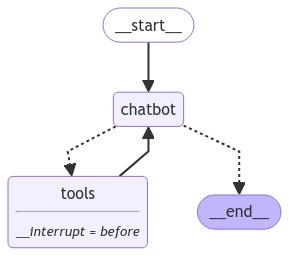

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
# Function to generate a unique session ID
import uuid

def generate_session_id() -> str:
    return str(uuid.uuid4())

In [17]:
# Generating a dynamic session ID
thread_id_1 = generate_session_id()

In [18]:
config_1 = {"configurable": {"thread_id": thread_id_1}}

In [19]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config_1, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_JHQdQgDRhPp0cwITnVJTNfat)
 Call ID: call_JHQdQgDRhPp0cwITnVJTNfat
  Args:
    query: LangGraph


## The execution was interrupted !
Notice that unlike last time, the "next" node is set to 'tools'. We've interrupted here!



In [20]:
snapshot = graph.get_state(config_1)
snapshot.next

('tools',)

### Let's check the tool invocation details

In [23]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': 'call_JHQdQgDRhPp0cwITnVJTNfat',
  'type': 'tool_call'}]

# How to Continue execution?

So far, all of this is an exact repeat of the previous section. The LLM just requested to use the search engine tool and our graph was interrupted. 

If we proceed as before, the tool will be called to search the web.

But what if the user wants to intercede? What if we think the chat bot doesn't need to use the tool?

Let's directly provide the correct response!

### How do we do that

1) The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
And then directly "put words in the LLM's mouth" by populating its response.

2) We then use ```update_state``` to update the state for the ```config_1``` thread.
Please note that we append the message to the existing state.


### We will review how to update existing messages in the next section!

In [24]:
from langchain_core.messages import AIMessage, ToolMessage

answer = ("LangGraph is a library for building stateful, multi-actor applications with LLMs.")
new_messages = [
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    AIMessage(content=answer),
]

In [25]:
new_messages[-1].pretty_print()

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


In [26]:
graph.update_state(
    config_1,
    {"messages": new_messages},
)

{'configurable': {'thread_id': 'd86e9e47-c4f9-4153-9ce9-04ed1ad626a0',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef637ac-ebf5-6620-8003-253550c75566'}}

In [27]:
print("\n\nLast 2 messages;")
print(graph.get_state(config_1).values["messages"][-2:])



Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='2e93d92f-cb37-4d6b-8759-ae0bb90a2d86', tool_call_id='call_JHQdQgDRhPp0cwITnVJTNfat'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='c648add1-f6ae-4e4e-b92a-5b692e5b6020')]


Now the graph is complete, since we've provided the final response message! 

Since state updates simulate a graph step, they even generate corresponding traces. 

Inspec the LangSmith trace of the update_state call above to see what's going on.

https://smith.langchain.com/public/c45207bb-bd26-4c9a-b631-928bbeebfbcb/r

# What actually happened in update_state?
Notice that our new messages are appended to the messages already in the state. Remember how we defined the State type?

```Python
class State(TypedDict):
    messages: Annotated[list, add_messages]
```

We annotated messages with the pre-built add_messages function. 

This instructs the graph to always append values to the existing list, rather than overwriting the list directly. 

The same logic is applied here, so the messages we passed to ```update_state``` were appended in the same way!



# Update state as if the message is coming from the chatbot


The ```update_state``` function operates as if it were one of the nodes in your graph! 

By default, the update operation uses the node that was last executed, but you can manually specify it below. 

Let's add an update and tell the graph to treat it as if it came from the "chatbot" using ```as_node```


Which node for this function to act as. It will automatically continue processing as if this node just ran.

In [28]:
graph.update_state(
    config_1,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    as_node="chatbot",
)

{'configurable': {'thread_id': 'd86e9e47-c4f9-4153-9ce9-04ed1ad626a0',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef637b9-95e9-650e-8004-65fdb71b4b8e'}}

Check out the LangSmith trace for this update call at the provided link. Notice from the trace that the graph continues into the tools_condition edge. We just told the graph to treat the update as_node="chatbot". If we follow the diagram below and start from the chatbot node, we naturally end up in the tools_condition edge and then __end__ since our updated message lacks tool calls.
    
https://smith.langchain.com/public/ce83989f-6e49-4bdd-bcd5-f54ca55c8d00/r/30b1406a-ae5b-4e9e-9fe5-032be6efb92e

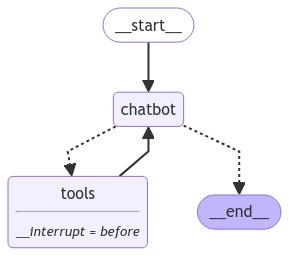

In [29]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Inspect the state
Inspect the current state as before to confirm the checkpoint reflects our manual updates.

In [30]:
snapshot = graph.get_state(config_1)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='2e93d92f-cb37-4d6b-8759-ae0bb90a2d86', tool_call_id='call_JHQdQgDRhPp0cwITnVJTNfat'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='c648add1-f6ae-4e4e-b92a-5b692e5b6020'), AIMessage(content="I'm an AI expert!", id='48d534ba-bba2-4c26-a250-e6914f1c0326')]
()


### How does the graph know that it has entered a finish state?

Notice: that we've continued to add AI messages to the state. Since we are acting as the chatbot and responding with an AIMessage that doesn't contain tool_calls, the graph knows that it has entered a finished state (next is empty).

# Overwrite existing messages
The add_messages function we used to annotate our graph's State above controls how updates are made to the messages key. 

This function looks at any message IDs in the new messages list. 

If the ID matches a message in the existing state, add_messages overwrites the existing message with the new content.



In [31]:
thread_id_2 = generate_session_id()

In [32]:
config_2 = {"configurable": {"thread_id": thread_id_2}}

In [33]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"

events = graph.stream(
    {"messages": [("user", user_input)]}, config_2, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_bNJCPNUpH6Qo2IgHLZYUMsCk)
 Call ID: call_bNJCPNUpH6Qo2IgHLZYUMsCk
  Args:
    query: LangGraph


# Tool Invokation Update
Next, let's update the tool invocation for our agent. Maybe we want to search for human-in-the-loop workflows in particular.

In [34]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config_2)
existing_message = snapshot.values["messages"][-1]

In [35]:
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])

Original
Message ID run-f4832a94-545b-4692-8e45-1bf8a3425238-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'call_bNJCPNUpH6Qo2IgHLZYUMsCk', 'type': 'tool_call'}


In [36]:
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"

In [37]:
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

In [38]:
print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)

Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'call_bNJCPNUpH6Qo2IgHLZYUMsCk', 'type': 'tool_call'}
Message ID run-f4832a94-545b-4692-8e45-1bf8a3425238-0


In [39]:
graph.update_state(config_2, {"messages": [new_message]})

{'configurable': {'thread_id': '91398486-14ed-4787-9864-38191327e1dc',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef637cf-c014-6c9e-8002-9d2132ce45e2'}}

In [40]:
print("\n\nTool calls")
graph.get_state(config_2).values["messages"][-1].tool_calls



Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': 'call_bNJCPNUpH6Qo2IgHLZYUMsCk',
  'type': 'tool_call'}]

Notice that we've modified the AI's tool invocation to search for "LangGraph human-in-the-loop workflow" instead of the simple "LangGraph".
    
Check out the LangSmith trace to see the state update call - you can see our new message has successfully updated the previous AI message.

https://smith.langchain.com/public/cd7c09a6-758d-41d4-8de1-64ab838b2338/r

# Resume the Graph
Resume the graph by streaming with an input of None and the existing config.



In [41]:
events = graph.stream(None, config_2, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/how-tos/", "content": "Human in the Loop. One of LangGraph's main benefits is that it makes human-in-the-loop workflows easy. These guides cover common examples of that. How to add breakpoints. How to edit graph state. How to wait for user input. How to view and update past graph state. Review tool calls."}, {"url": "https://www.youtube.com/watch?v=9BPCV5TYPmg", "content": "In this video, I'll show you how to handle persistence with LangGraph, enabling a unique Human-in-the-Loop workflow. This approach allows a human to grant an..."}]
================================== Ai Message ==================================

Here are some resources and insights about LangGraph, particularly focusing on its human-in-the-loop workflow:

1. **Human-in-the-Loop Workflows**: LangGraph facilitates easy integration of human-in-the-loop wor

Check out the trace to see the tool call and later LLM response. Notice that now the graph queries the search engine using our updated query term - we were able to manually override the LLM's search here!

https://smith.langchain.com/public/2d633326-14ad-4248-a391-2757d01851c4/r/6464f2f2-edb4-4ef3-8f48-ee4e249f2ad0


All of this is reflected in the graph's checkpointed memory, meaning if we continue the conversation, it will recall all the modified state.





In [42]:
events = graph.stream(
    {
        "messages": (
            "user",
            "Remember what I'm learning about?",
        )
    },
    config_2,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember what I'm learning about?
================================== Ai Message ==================================

Yes, you're learning about LangGraph, particularly focusing on its human-in-the-loop workflow and how it facilitates various tasks within that framework. If you have specific areas or questions you want to explore further, feel free to let me know!


# Summary:

We've used ```interrupt_before``` and ```update_state``` to manually modify the state as a part of a human-in-the-loop workflow. 

Interruptions and state modifications let you control how the agent behaves. 

Combined with persistent checkpointing, it means you can ```pause``` an action and ```resume``` at any point. 

Your user doesn't have to be available when the graph interrupts!

The graph code for this section is identical to previous ones. 

The key snippets to remember are to add ````.compile(..., interrupt_before=[...])```` 

(or ```interrupt_after```) if you want to explicitly pause the graph whenever it reaches a node. 

Then you can use update_state to modify the checkpoint and control how the graph should proceed.